In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix


# Load data

In [2]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
290,54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
291,56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
292,58,0,2,180,393,0,0,110,1,1.0,2,?,7,1


# EDA

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

In [4]:
df = df.rename(columns={'num       ': 'num'})

In [5]:
df.num.unique()

array([0, 1])

In [6]:
df.slope.value_counts()

?    190
2     91
1     12
3      1
Name: slope, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    object 
 4   chol      294 non-null    object 
 5   fbs       294 non-null    object 
 6   restecg   294 non-null    object 
 7   thalach   294 non-null    object 
 8   exang     294 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     294 non-null    object 
 11  ca        294 non-null    object 
 12  thal      294 non-null    object 
 13  num       294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [8]:
df.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [9]:
missing_data = df.isnull().sum()
missing_data

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

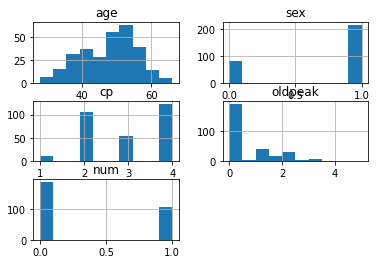

In [10]:
df.hist();

# Data processing

In [11]:
# df = df.drop(['slope', 'ca', 'thal'], axis =1)

In [12]:
df.replace('?',np.nan, inplace=True)
df.fillna(value=0,inplace=True)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,0,0,0,0
1,29,1,2,120,243,0,0,160,0,0.0,0,0,0,0
2,29,1,2,140,0,0,0,170,0,0.0,0,0,0,0
3,30,0,1,170,237,0,1,170,0,0.0,0,0,6,0
4,31,0,2,100,219,0,1,150,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,0,0,0,1
290,54,0,3,130,294,0,1,100,1,0.0,2,0,0,1
291,56,1,4,155,342,1,0,150,1,3.0,2,0,0,1
292,58,0,2,180,393,0,0,110,1,1.0,2,0,7,1


In [13]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'slope',
 'ca',
 'thal']

In [14]:
for col in cat_cols:
    df[col] = df[col].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    int64  
 4   chol      294 non-null    int64  
 5   fbs       294 non-null    int64  
 6   restecg   294 non-null    int64  
 7   thalach   294 non-null    int64  
 8   exang     294 non-null    int64  
 9   oldpeak   294 non-null    float64
 10  slope     294 non-null    int64  
 11  ca        294 non-null    int64  
 12  thal      294 non-null    int64  
 13  num       294 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.3 KB


In [15]:
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
102,49,0,2,110,0,0,0,160,0,0.0,0,0,0,0


In [16]:
df[df['age'] == 49]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
101,49,0,2,110,0,0,0,160,0,0.0,0,0,0,0
102,49,0,2,110,0,0,0,160,0,0.0,0,0,0,0
103,49,0,2,124,201,0,0,164,0,0.0,0,0,0,0
104,49,0,3,130,207,0,1,135,0,0.0,0,0,0,0
105,49,1,2,100,253,0,0,174,0,0.0,0,0,0,0
106,49,1,3,140,187,0,0,172,0,0.0,0,0,0,0
107,49,1,4,120,297,0,0,132,0,1.0,2,0,0,0
108,49,1,4,140,0,0,0,130,0,0.0,0,0,0,0
209,49,0,3,160,180,0,0,156,0,1.0,2,0,0,1
210,49,1,3,115,265,0,0,175,0,0.0,0,0,0,1


In [17]:
df = df.drop_duplicates()
df[df['age'] == 49]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
101,49,0,2,110,0,0,0,160,0,0.0,0,0,0,0
103,49,0,2,124,201,0,0,164,0,0.0,0,0,0,0
104,49,0,3,130,207,0,1,135,0,0.0,0,0,0,0
105,49,1,2,100,253,0,0,174,0,0.0,0,0,0,0
106,49,1,3,140,187,0,0,172,0,0.0,0,0,0,0
107,49,1,4,120,297,0,0,132,0,1.0,2,0,0,0
108,49,1,4,140,0,0,0,130,0,0.0,0,0,0,0
209,49,0,3,160,180,0,0,156,0,1.0,2,0,0,1
210,49,1,3,115,265,0,0,175,0,0.0,0,0,0,1
211,49,1,4,130,206,0,0,170,0,0.0,0,0,0,1


In [18]:
warnings.filterwarnings('ignore')

my_scaler = MinMaxScaler()
df[['age']] = my_scaler.fit_transform(df[['age']])
df[['trestbps']] = my_scaler.fit_transform(df[['trestbps']])
df[['chol']] = my_scaler.fit_transform(df[['chol']])
df[['thalach']] = my_scaler.fit_transform(df[['thalach']])

# Model

In [19]:
X = df.drop(['num'], axis = 1)
y = df.num.values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [21]:
xg_class = xgb.XGBClassifier(learning_rate = 0.01)
xg_class.fit(X_train, y_train)

[16:32:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
xg_class.score(X_train, y_train)

0.9178082191780822

In [23]:
xg_class.score(X_test, y_test)

0.8108108108108109

In [24]:
test_hypotheses = xg_class.predict(X_test)

print(classification_report(test_hypotheses, y_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        55
           1       0.61      0.74      0.67        19

    accuracy                           0.81        74
   macro avg       0.76      0.79      0.77        74
weighted avg       0.83      0.81      0.82        74



Accuracy: 0.8108108108108109


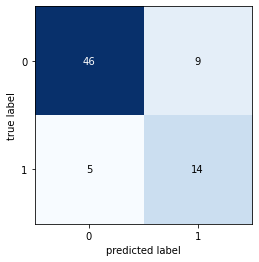

In [25]:
cm = confusion_matrix(test_hypotheses, y_test)
plot_confusion_matrix(cm)

print(f'Accuracy: {accuracy_score(test_hypotheses, y_test)}')